In [14]:
# pip install -U langchain-tavily

In [15]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=3)
tools=[tool]

In [16]:
tool.invoke("what is sagara global ai company")

{'query': 'what is sagara global ai company',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Sagara Global',
   'url': 'https://sagaraglobal.com/',
   'content': 'Sagara Global Services AI Development Services Application Development Services Products HM Textiles SAGARA GLOBAL With AI Agents That Learn, Adapt & Deliver Smarter Workflows Start Here — With AI Agents That Learn, Adapt & Deliver Our Services Know More → End-to-end web and mobile application development services to bring your digital ideas to life. Know More → OUR PRODUCTS Explore our range of high-quality products designed to meet your needs. From modern solutions to traditional craftsmanship, we have something for everyone. Know more Click here to know more HM Textiles A pan-India textile brand offering a variety of quality fabrics and sarees for wholesale buyers. Know more Click here to know more Services Products © 2025 SAGARA GLOBAL | All rights reserved.',
   'score': 0.7293082,


In [17]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [18]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [19]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
graph_builder = StateGraph(State)

In [20]:
llm_tools=llm.bind_tools(tools)
def chatbot(state:State):
    result=llm_tools.invoke(state['messages'])
    return {'messages':result}

In [21]:
graph_builder.add_node("chatbot", chatbot)


In [22]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [23]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

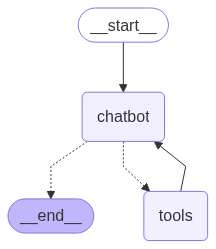

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value['messages'].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hi there! How can I help you today?
Assistant: Hi there! How can I help you today?
Assistant: What is your question?
Assistant: I am Gemini, a large language model built by Google.


/workspaces/Langgraph/.venv/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1501: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?
Assistant: 
